In [39]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
import json
import pickle
import os
import sys
from tqdm import tqdm
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from functools import partial
from sklearn.metrics import mean_squared_error as mse, \
                            mean_absolute_error as mae, \
                            r2_score as r2
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm import tqdm
import gc

In [40]:
def discriminador(row):
    mean = np.mean(row)
    std = np.std(row)
    threshold = 3 * std
    outlier = np.abs(row - mean) > threshold
    return outlier

def get_model(initial_path):
    models = {}
    for inv_dir in os.listdir(initial_path):
        if ("inversor" in inv_dir.lower()) & (os.path.isdir(os.path.join(initial_path, inv_dir))):
            explotacion_path = os.path.join(initial_path, inv_dir, "Explotacion_15")
            for model_dir in os.listdir(explotacion_path):
                model_path = os.path.join(explotacion_path, model_dir)
                if os.path.isdir(model_path):
                    model_dict = {}
                    with open(os.path.join(model_path, "model.model"), "rb") as f:
                        model_dict["model"] = pickle.load(f)
                    with open(os.path.join(model_path, "informe_modelo.json"), "r") as f:
                        informe_modelo = json.load(f)
                        if "intervalo_min" in informe_modelo:
                            model_dict["intervalo"] = informe_modelo["intervalo_min"]
                        model_dict["normalizacion"] = informe_modelo["normalizacion"]
                        model_dict["RMSE"] = informe_modelo["metricas"]["RMSE"]
                        model_dict["RMSE_rad"] = informe_modelo["metricas_rad"]
                    models[inv_dir] = model_dict
    return models    


In [41]:
class MultiOutputOpt(BaseEstimator, TransformerMixin):
    def __init__(self, model_class=XGBRegressor, device="cpu", trials=None):
        self.model_class = model_class
        self.device = device
        self.models = {}  
        self.trials = trials if trials is not None else {}
        try:
            print(len(self.trials[0].trials))
        except:
            pass
        self.params = {}
        
    def objective(self, space_params, train_set, cv_folds):
        n_estimators = int(space_params.pop('n_estimators'))
        params = {'device': self.device,
            'objective': 'reg:squarederror', 
            'tree_method': "hist", 
            'random_state': 42,
            'n_jobs': -1}
        params = {**params, **space_params}
        if 'max_depth' in params:
            params['max_depth'] = int(params['max_depth'])
        if 'min_child_weight' in params:
            params['min_child_weight'] = max(1, int(params['min_child_weight']))
        print
        cv_result = xgb.cv(params, train_set, nfold = cv_folds, num_boost_round = n_estimators, early_stopping_rounds = 100, metrics = 'rmse', as_pandas = True)
        score = cv_result['test-rmse-mean'].min()
        return {'loss': score, 'status': STATUS_OK}
        
    def optimize(self, X, y, space, cv_folds, gamma_algo = 1, STALL_LIMIT = 5, MAX_EVALS_PER_RUN = 250):
        for col in tqdm(range(y.shape[1]), total = y.shape[1]):
            if self.params.get(col) is not None:
                space.update(self.params[col])
            train_set = xgb.DMatrix(X, label=y[:, col])
            trials = Trials()
            TOTAL_EVALS = len(trials.trials)
            STALL_LIMIT = STALL_LIMIT
            MAX_EVALS_PER_RUN = MAX_EVALS_PER_RUN
            best_loss = np.inf
            stall_counter = 0
            num_evals = TOTAL_EVALS
            run_counter = 0
            upper_limit = (MAX_EVALS_PER_RUN * (STALL_LIMIT - 1)) * 10
            while stall_counter < STALL_LIMIT and num_evals < TOTAL_EVALS + upper_limit:
                best = fmin(fn=lambda space: self.objective(space, train_set = train_set, cv_folds = cv_folds), 
                        space = space, 
                        algo = partial(tpe.suggest, gamma = gamma_algo),
                        max_evals = num_evals + MAX_EVALS_PER_RUN, 
                        trials = trials,
                        verbose = False)  # Cambiado a True para que devuelva los parámetros óptimos
                best_params = space_eval(space, best)  # Obtener los parámetros óptimos en su forma original
                new_loss = trials.best_trial['result']['loss']
                if new_loss < best_loss:
                    threshold = 0.001
                    if abs(new_loss - best_loss) <= threshold:
                        stall_counter += 1
                    else:
                        stall_counter = 0
                    best_loss = new_loss
                else:
                    stall_counter += 1
                num_evals += MAX_EVALS_PER_RUN
                run_counter += 1
                gamma_algo -= 0.05
            print(f"\tEntrenamiento para entrada {col+1} finalizado")
            print(f"\tNúmero de evaluaciones realizadas: {num_evals}")
            print(f"\tBest params: {best_params}")
            print(f"\tBest loss: {best_loss}")

            final_params = {"device": self.device,
                        "objective": 'reg:squarederror', 
                        "tree_method": "hist",
                        "n_jobs": -1}
            final_params = {**final_params, **best_params}
            final_params.pop('n_estimators')
            if 'max_depth' in final_params:
                final_params['max_depth'] = int(final_params['max_depth'])
            if 'min_child_weight' in final_params:
                final_params['min_child_weight'] = max(1, int(final_params['min_child_weight']))
            model = xgb.train(final_params, train_set, num_boost_round = int(best_params['n_estimators']))
            self.models[col] = model
            self.trials[col] = trials
            self.params[col] = best_params  # Guardar los parámetros óptimos en su forma original

    def predict(self, X):
        predictions = []
        dmatrix = xgb.DMatrix(X)
        for col, model in self.models.items():
            pred = model.predict(dmatrix)
            predictions.append(pred)
        return np.column_stack(predictions)
    

In [42]:
model_name = "XGBRegressor"
root_path = "/home/upo/Desktop/Test_FVPredictive/FVPredictive_TEST/Galisteo"
#root_path = os.getcwd()

valid_responses = ["y", "n"]
promediado = ""
while promediado not in valid_responses:
    promediado = input("¿Desea promediar los datos de entrada? (Y/N): ").lower()
promediado = promediado == "y"

if promediado:
    current_models = get_model(os.path.join(root_path, "Modelos", "entrada_amperaje_multi_promediado"))
else:
    current_models = get_model(os.path.join(root_path, "Modelos", "entrada_amperaje_multi"))
    
intervalo = current_models["Inversor_1"]["intervalo"]
normalizacion = current_models["Inversor_1"]["normalizacion"]
print(f"\nLas opciones seleccionadas son: \nModelo: {model_name} \
    \nPromediado: {promediado} \
    \n\tIntervalo: {intervalo} \
    \nNormalización: {normalizacion}", end="\n\n")

params = None
for filename in os.listdir(root_path):
    if "params.json" in filename:
        with open(os.path.join(root_path, filename)) as f:
            params = json.load(f)
if params is None:
    print("No se ha encontrado el archivo de parámetros para la conexión a la base de datos")
    sys.exit()
data_path = os.path.join(root_path, params["data_path"])
schema_name = params["schema"]

password = params['password'].replace('@', '%40')
engine = create_engine(f'postgresql://{params["user"]}:{password}@{params["host"]}:{params["port"]}/{params["dbname"]}')
print(f"Conexión a la base de datos {params['dbname']} (esquema {schema_name}) establecida")


Las opciones seleccionadas son: 
Modelo: XGBRegressor     
Promediado: True     
	Intervalo: 15     
Normalización: True

Conexión a la base de datos fvpredictive (esquema galisteo) establecida


In [43]:
num_mod_string = 30
sup_mod = 2
# Carga de los datos de entrenamiento y modelos de potencia
if promediado:
    main_query = f"""
            WITH inv AS (
                SELECT 
                    date_trunc('hour', datetime_utc) + 
                    INTERVAL '{intervalo} min' * floor(date_part('minute', datetime_utc) / {intervalo}) as datetime_utc_rounded,
                    dispositivo_id,
                    MIN(inv.id) AS id, 
                    AVG(potencia_act) as potencia_act, 
                    AVG(amp_dc) as amp_dc,
                    det.entrada_id
                FROM {schema_name}.inversores AS inv
                JOIN {schema_name}.inversores_detalle AS det
                    ON inv.id = det.id
                WHERE EXTRACT(YEAR FROM datetime_utc) = 2024
                GROUP BY datetime_utc_rounded, dispositivo_id, det.entrada_id 
            ),
            stats AS (
                SELECT
                    datetime_utc,
                    dispositivo_id,
                    COALESCE(rad_poa - LAG(rad_poa) OVER (PARTITION BY dispositivo_id ORDER BY datetime_utc) / NULLIF(rad_poa, 0), 0) AS diff_rad_poa
                FROM {schema_name}.meteo
                WHERE EXTRACT(YEAR FROM datetime_utc) = 2024
                ORDER BY 1,2
            ),
            met AS (
                SELECT 
                    date_trunc('hour', meteo.datetime_utc) + 
                    INTERVAL '{intervalo} min' * floor(date_part('minute', meteo.datetime_utc) / {intervalo}) as datetime_utc_rounded, 
                    meteo.dispositivo_id,
                    AVG(rad_poa) AS rad_poa,
                    AVG(rad_celda1) AS rad_celda1,
                    AVG(rad_celda2) AS rad_celda2, 
                    AVG(temp_amb) AS temp_amb, 
                    AVG(temp_panel1) AS temp_panel1,
                    AVG(temp_panel2) AS temp_panel2, 
                    AVG(cloud_impact) AS cloud_impact,
                    BOOL_OR(daylight) AS daylight,
                    STDDEV(rad_poa)/NULLIF(AVG(rad_poa), 0) AS std_rad_poa,     -- Desviación estándar del promedio de radiación inclinada durante el intervalo
                    STDDEV(diff_rad_poa) AS std_diff_rad_poa                    -- Desviación estándar de la diferencia promedio de radiación inclinada durante el intervalo
                FROM {schema_name}.meteo
                JOIN stats
                    ON stats.datetime_utc = meteo.datetime_utc
                        AND stats.dispositivo_id = meteo.dispositivo_id
                WHERE daylight = true
                GROUP BY meteo.dispositivo_id, datetime_utc_rounded
            )
            SELECT 
                inv.id,
                inv.dispositivo_id,
                inv.entrada_id,
                inv.datetime_utc_rounded as datetime_utc, 
                potencia_act,  
                num_strings, 
                rad_poa,
                std_rad_poa,
                std_diff_rad_poa,
                rad_celda1, 
                rad_celda2, 
                temp_amb, 
                temp_panel1, 
                temp_panel2,
                cloud_impact,
                motivo,
                consigna_pot_act_planta,
                amp_dc
            FROM inv
            JOIN {schema_name}.distrib_inversores dist
                ON dist.dispositivo_id = inv.dispositivo_id
                    AND dist.entrada_id = inv.entrada_id
            JOIN {schema_name}.dispositivos AS disp
                ON disp.dispositivo_id = inv.dispositivo_id
            JOIN met
                ON met.datetime_utc_rounded = inv.datetime_utc_rounded
                    AND met.dispositivo_id = disp.meteo_cercana_id
            JOIN {schema_name}.ree AS ree
                ON ree.datetime_utc = inv.datetime_utc_rounded
            ORDER BY 5, 2, 3, 4;"""
else:
    main_query = f"""
        WITH f AS (
            SELECT *
                FROM {schema_name}.inversores
                WHERE (EXTRACT(MINUTE FROM datetime_utc) %% 5 = 0)
                    AND (EXTRACT(SECOND FROM datetime_utc) = 0)
                    AND (EXTRACT(MONTH FROM datetime_utc) != 10)
                ORDER BY datetime_utc)
        SELECT f.id, f.dispositivo_id, det.entrada_id, f.datetime_utc, potencia_act, num_strings, 
                rad_poa, rad_celda1, rad_celda2, temp_amb, temp_panel1, temp_panel2, cloud_impact, 
                motivo, consigna_pot_act_planta, amp_dc
            FROM f
            JOIN {schema_name}.inversores_detalle AS det
                ON f.id = det.id
            JOIN {schema_name}.distrib_inversores dist
                ON  dist.dispositivo_id = f.dispositivo_id
                    AND dist.entrada_id = det.entrada_id
            JOIN {schema_name}.dispositivos AS disp
                ON disp.dispositivo_id = f.dispositivo_id
            JOIN {schema_name}.meteo AS met
                ON met.dispositivo_id = disp.meteo_cercana_id
                    AND met.datetime_utc = f.datetime_utc
            JOIN {schema_name}.ree AS ree
                ON ree.datetime_utc = f.datetime_utc
            WHERE daylight = true
            ORDER BY 4, 2, 3;"""

chunksize = 100000
chunks = pd.read_sql_query(main_query, engine, chunksize=chunksize)
main_df = pd.DataFrame()
for chunk in chunks:
    main_df = pd.concat([main_df, chunk], ignore_index = True)
del chunks, chunk
gc.collect()

0

In [44]:
# Normalización de la entrada de corriente continua, formateo de fechas y escalado de potencia
print(f"Carga inicial de {main_df.shape[0]} registros")
if normalizacion:
    print("Entrada de corriente continua normalizada según el número de strings")
    main_df["amp_dc"] = main_df["amp_dc"]/main_df["num_strings"]
else:
    print("Entrada de corriente continua sin normalizar")
main_df["datetime_utc"] = pd.to_datetime(main_df["datetime_utc"], utc = True)
main_df["potencia_act"] = main_df["potencia_act"] * 1000

Carga inicial de 256768 registros
Entrada de corriente continua normalizada según el número de strings


In [45]:
# Pivotado de las entradas de corriente continua
y = main_df.pivot(index=["dispositivo_id", "datetime_utc"], columns='entrada_id', values='amp_dc')
y.columns = ["amp_dc_" + str(col) for col in y.columns]
print(f"Número de registros del dataframe tras pivotar: {y.shape[0]}")

Número de registros del dataframe tras pivotar: 16048


In [46]:
# Rellenado de valores faltantes por desconexión de entradas
consulta_sql = f"""SELECT MAX(entrada_id)
            FROM {schema_name}.distrib_inversores;"""
max_entradas = pd.read_sql_query(consulta_sql, engine).values[0][0]
entradas = [i for i in range(1, max_entradas + 1)]
for dispositivo in y.index.get_level_values(0).unique():
    consulta_sql = f"""SELECT entrada_id
                FROM {schema_name}.distrib_inversores
                WHERE dispositivo_id = {dispositivo};"""
    entradas_inv = pd.read_sql_query(consulta_sql, engine).values.reshape(1,-1)[0]
    entradas_off = list(set(entradas) - set(entradas_inv))
    for entrada in entradas_off:
        y.loc[dispositivo, "amp_dc_" + str(entrada)] = 0

In [47]:
X = main_df.drop(columns=["entrada_id", "amp_dc"]).drop_duplicates(subset=["id", "datetime_utc"]).set_index(["dispositivo_id", "datetime_utc"])

In [48]:
# Manipulación de variables meteorológicas
X["rad_diff"] = (X["rad_celda1"] - X["rad_celda2"]) / X["rad_celda1"]
X["temp_panel"] = (((X["temp_panel1"] + X["temp_panel2"]) / 2)) - X["temp_amb"]
X = X.drop(columns = ["rad_celda1", "rad_celda2", "temp_panel1", "temp_panel2"])

In [49]:
# Manipulación de variables de consigna
X["motivo"] = X["motivo"].apply(lambda x: 0 if x == 0 else (2 if x == 7 else 1))  # Clusterización?
main_query = f"""
    SELECT MAX(consigna_pot_act_planta)
        FROM {schema_name}.ree AS ree;"""
max_pot_act = pd.read_sql_query(main_query, engine).values[0][0]
X["consigna_pot_act_planta"] = X["consigna_pot_act_planta"] / max_pot_act   # Valor normalizado

In [50]:
# Asignación de variables temporales
X["dia_año"] = X.index.get_level_values("datetime_utc").dayofyear
X["dia_año_sen"] = np.sin(X["dia_año"] * (2*np.pi/365))
X["hora_seg"] = X.index.get_level_values("datetime_utc").hour * 3600 + \
                        X.index.get_level_values("datetime_utc").minute * 60 + \
                        X.index.get_level_values("datetime_utc").second
X["hora_seg_sen"] = np.sin(X["hora_seg"] * (2*np.pi/86400))

In [51]:
# Escalado de variables porcentuales
X[['cloud_impact']] = X[['cloud_impact']].apply(lambda x: x/100)

In [52]:
X["std_rad_poa"] = (X["std_rad_poa"]) + 1
X["std_diff_rad_poa"] = (np.sqrt(X["std_diff_rad_poa"]) / 10) + 1
X = X.join(X.groupby([X.index.get_level_values("dispositivo_id"), X.index.get_level_values("datetime_utc").date])["rad_poa"]\
    .rolling(window=4, min_periods=1)\
        .apply(lambda x: np.abs(x.pct_change()).mean() + 1)\
            .fillna(2)\
                .droplevel([0,1])\
                    .rename("mean_pct_change"))
X["coef"] = X["std_rad_poa"] * X["mean_pct_change"]

In [53]:
X["coef"].describe()

count    16009.000000
mean         1.564924
std          0.890130
min          1.005532
25%          1.101813
50%          1.263625
75%          1.598678
max         24.266054
Name: coef, dtype: float64

In [54]:
X["cloud_impact"].describe()

count    16048.000000
mean         0.620926
std          0.391582
min          0.011238
25%          0.208411
50%          0.729981
75%          1.000000
max          1.523950
Name: cloud_impact, dtype: float64

In [55]:
X["coef"].quantile([0.95])

0.95    3.213039
Name: coef, dtype: float64

<Axes: >

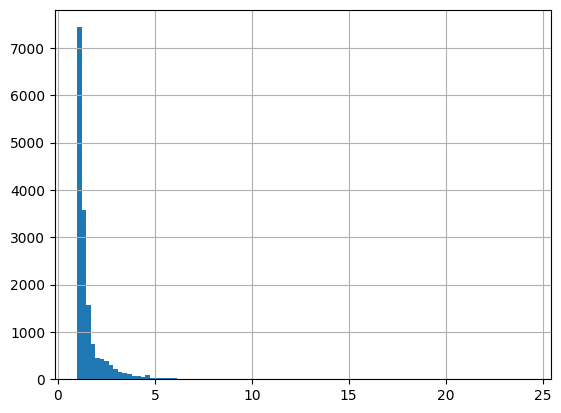

In [56]:
X["coef"].hist(bins=100)

In [57]:
X = X.drop(columns = ["id",
                    "potencia_act",
                    "num_strings",
                    "dia_año",
                    "hora_seg"
                    ]).sort_index()
y = y.sort_index()

In [58]:
pred_df = pd.DataFrame()
for current_model in current_models:
    model = current_models[current_model]["model"]
    X_disp = X.loc[X.index.get_level_values("dispositivo_id") == int(current_model.split("_")[1])+20]
    y_disp = y.loc[y.index.get_level_values("dispositivo_id") == int(current_model.split("_")[1])+20]
    
    X_prep = model.named_steps["preprocessor"].transform(X_disp.drop(columns=["std_rad_poa",
                                                                                "std_diff_rad_poa",
                                                                                "coef"]))
    dtrain = xgb.DMatrix(X_prep)
    y_pred = model.named_steps["regressor"].predict(dtrain)

    consulta_sql = f"""SELECT num_strings
                    FROM {schema_name}.distrib_inversores
                    WHERE dispositivo_id = {int(current_model.split("_")[1])+20};"""
    num_strings = pd.read_sql_query(consulta_sql, engine).values.reshape(1, -1)
    if normalizacion:
        y_pred_reesc = y_pred * num_strings
        y_reesc = y_disp * num_strings
    else:
        y_pred_reesc = y_pred
        y_reesc = y_disp

    y_reesc = y_reesc.reset_index()
    pred_inv_df = y_reesc.melt(id_vars=["dispositivo_id", "datetime_utc"], var_name="entrada_id", value_name="amp_dc").sort_values(by=["dispositivo_id", "datetime_utc"])
    pred_inv_df["entrada_id"] = pred_inv_df["entrada_id"].str.split("_").str[2].astype(int)
    pred_inv_df["amp_dc_pred"] = y_pred_reesc.flatten()

    pred_inv_df = pd.merge(pred_inv_df, X_disp[["rad_poa", "std_rad_poa", "std_diff_rad_poa", "coef"]].reset_index(), on=["dispositivo_id", "datetime_utc"], how="inner")
    rad_metrics = current_models[current_model]["RMSE_rad"]
    labels = list(rad_metrics.keys())
    bins = [0] + [int(bin.split("-")[1]) for bin in labels[:-1]] + [np.inf]
    pred_inv_df["rad_bin"] = pd.cut(pred_inv_df["rad_poa"], bins=bins, labels=labels)
    pred_inv_df["error"] = pred_inv_df["amp_dc"] - pred_inv_df["amp_dc_pred"]
    pred_inv_df["soft_int_lim"] = np.abs(pred_inv_df["error"]) > pred_inv_df["rad_bin"].map(rad_metrics).astype(float) * pred_inv_df["coef"]
    pred_inv_df["med_int_lim"] = np.abs(pred_inv_df["error"]) > 2 * pred_inv_df["rad_bin"].map(rad_metrics).astype(float) * pred_inv_df["coef"]
    pred_inv_df["hard_int_lim"] = np.abs(pred_inv_df["error"]) > 3 * pred_inv_df["rad_bin"].map(rad_metrics).astype(float) * pred_inv_df["coef"]
    pred_inv_df["soft_lim"] = np.abs(pred_inv_df["error"]) > pred_inv_df["rad_bin"].map(rad_metrics).astype(float)
    pred_inv_df["med_lim"] = np.abs(pred_inv_df["error"]) > 2 * pred_inv_df["rad_bin"].map(rad_metrics).astype(float)
    pred_inv_df["hard_lim"] = np.abs(pred_inv_df["error"]) > 3 * pred_inv_df["rad_bin"].map(rad_metrics).astype(float)
    pred_df = pd.concat([pred_df, pred_inv_df], ignore_index=True)
pred_df = pred_df.sort_values(by=["dispositivo_id", "datetime_utc", "entrada_id"])


In [59]:
def is_outlier(group):
    error_mean = group["error"].mean()
    error_std = group["error"].std()
    return (group["error"] > error_mean + error_std) | (group["error"] < error_mean - error_std)

for name, group in pred_df.groupby(by=["dispositivo_id", "datetime_utc"]):
    outlier_mask = is_outlier(group)
    pred_df.loc[group.index, 'inv_outlier'] = outlier_mask

for name, group in pred_df.groupby(by=["datetime_utc"]):
    outlier_mask = is_outlier(group)
    pred_df.loc[group.index, 'plant_outlier'] = outlier_mask

pred_df

,dispositivo_id,datetime_utc,entrada_id,amp_dc,amp_dc_pred,rad_poa,std_rad_poa,std_diff_rad_poa,coef,rad_bin,error,soft_int_lim,med_int_lim,hard_int_lim,soft_lim,med_lim,hard_lim,inv_outlier,plant_outlier
39520,21,2024-01-01 07:45:00+00:00,1,-1.680000,4.092403,14.979310,1.371579,1.235935,7.721274,0-100,-5.772403,False,False,False,True,False,False,False,False
39521,21,2024-01-01 07:45:00+00:00,2,-0.770000,5.947500,14.979310,1.371579,1.235935,7.721274,0-100,-6.717500,False,False,False,True,False,False,False,False
39522,21,2024-01-01 07:45:00+00:00,3,1.110000,6.912929,14.979310,1.371579,1.235935,7.721274,0-100,-5.802929,False,False,False,True,False,False,False,False
39523,21,2024-01-01 07:45:00+00:00,4,1.160000,7.560161,14.979310,1.371579,1.235935,7.721274,0-100,-6.400161,False,False,False,True,False,False,False,False
39524,21,2024-01-01 07:45:00+00:00,5,4.963333,6.990119,14.979310,1.371579,1.235935,7.721274,0-100,-2.026786,False,False,False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157963,33,2024-01-31 17:30:00+00:00,12,8.893333,6.231751,14.740741,1.333493,1.221891,1.914070,0-100,2.661582,False,False,False,False,False,False,True,True
157964,33,2024-01-31 17:30:00+00:00,13,1.346667,6.190166,14.740741,1.333493,1.221891,1.914070,0-100,-4.843500,False,False,False,False,False,False,False,False
157965,33,2024-01-31 17:30:00+00:00,14,2.013333,6.899188,14.740741,1.333493,1.221891,1.914070,0-100,-4.885855,False,False,False,False,False,False,False,False
157966,33,2024-01-31 17:30:00+00:00,15,0.640000,5.530123,14.740741,1.333493,1.221891,1.914070,0-100,-4.890123,False,False,False,False,False,False,False,False


In [60]:
pred_df.iloc[:, -8:].sum().sort_values(ascending=False)

soft_lim         114305
soft_int_lim      67122
med_lim           53137
inv_outlier       51778
med_int_lim       26607
plant_outlier     26525
hard_lim          25103
hard_int_lim      20008
dtype: object

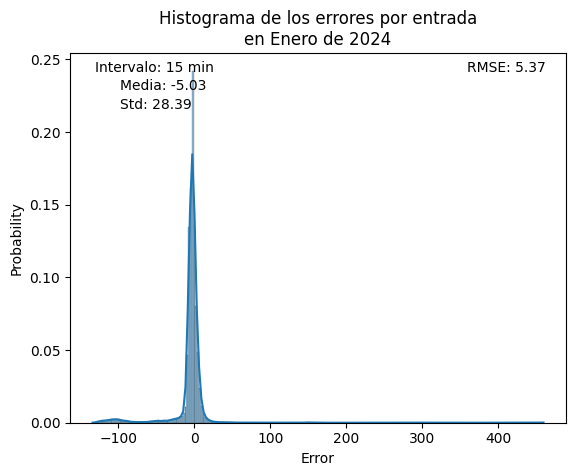

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=pred_df, x="error", kde=True, bins=250, stat="probability")
plt.xlabel("Error")
plt.title("Histograma de los errores por entrada\nen Enero de 2024")

# Calculate mean and standard deviation of the error
mean_error = pred_df["error"].mean()
std_error = pred_df["error"].std()

# Add text with mean and standard deviation
plt.text(0.05, 0.95, f"Intervalo: {intervalo} min", transform=plt.gca().transAxes)
plt.text(0.10, 0.9, f"Media: {mean_error:.2f}", transform=plt.gca().transAxes)
plt.text(0.10, 0.85, f"Std: {std_error:.2f}", transform=plt.gca().transAxes)
plt.text(0.80, 0.95, f"RMSE: {current_models[current_model]['RMSE']:.2f}", transform=plt.gca().transAxes)


plt.show()



In [62]:
pred_df["error"].describe()

count    256768.000000
mean         -5.034807
std          28.394091
min        -133.742280
25%          -6.010174
50%          -2.634441
75%           0.275473
max         459.405278
Name: error, dtype: float64

In [63]:
pred_df.groupby("rad_bin")["soft_int_lim"].mean() * 100



rad_bin
0-100      17.647123
100-250    24.690194
250-500    34.774745
500+       32.099922
Name: soft_int_lim, dtype: float64

In [64]:
soft_lim_percentage = pred_df.groupby("rad_bin")["med_int_lim"].mean() * 100
soft_lim_percentage

rad_bin
0-100       3.387952
100-250    11.399964
250-500    15.716458
500+       15.046969
Name: med_int_lim, dtype: float64

In [65]:
hard_lim_percentage = pred_df.groupby("rad_bin")["hard_int_lim"].mean() * 100
hard_lim_percentage

rad_bin
0-100       1.937370
100-250     9.779095
250-500    10.512578
500+       12.237195
Name: hard_int_lim, dtype: float64

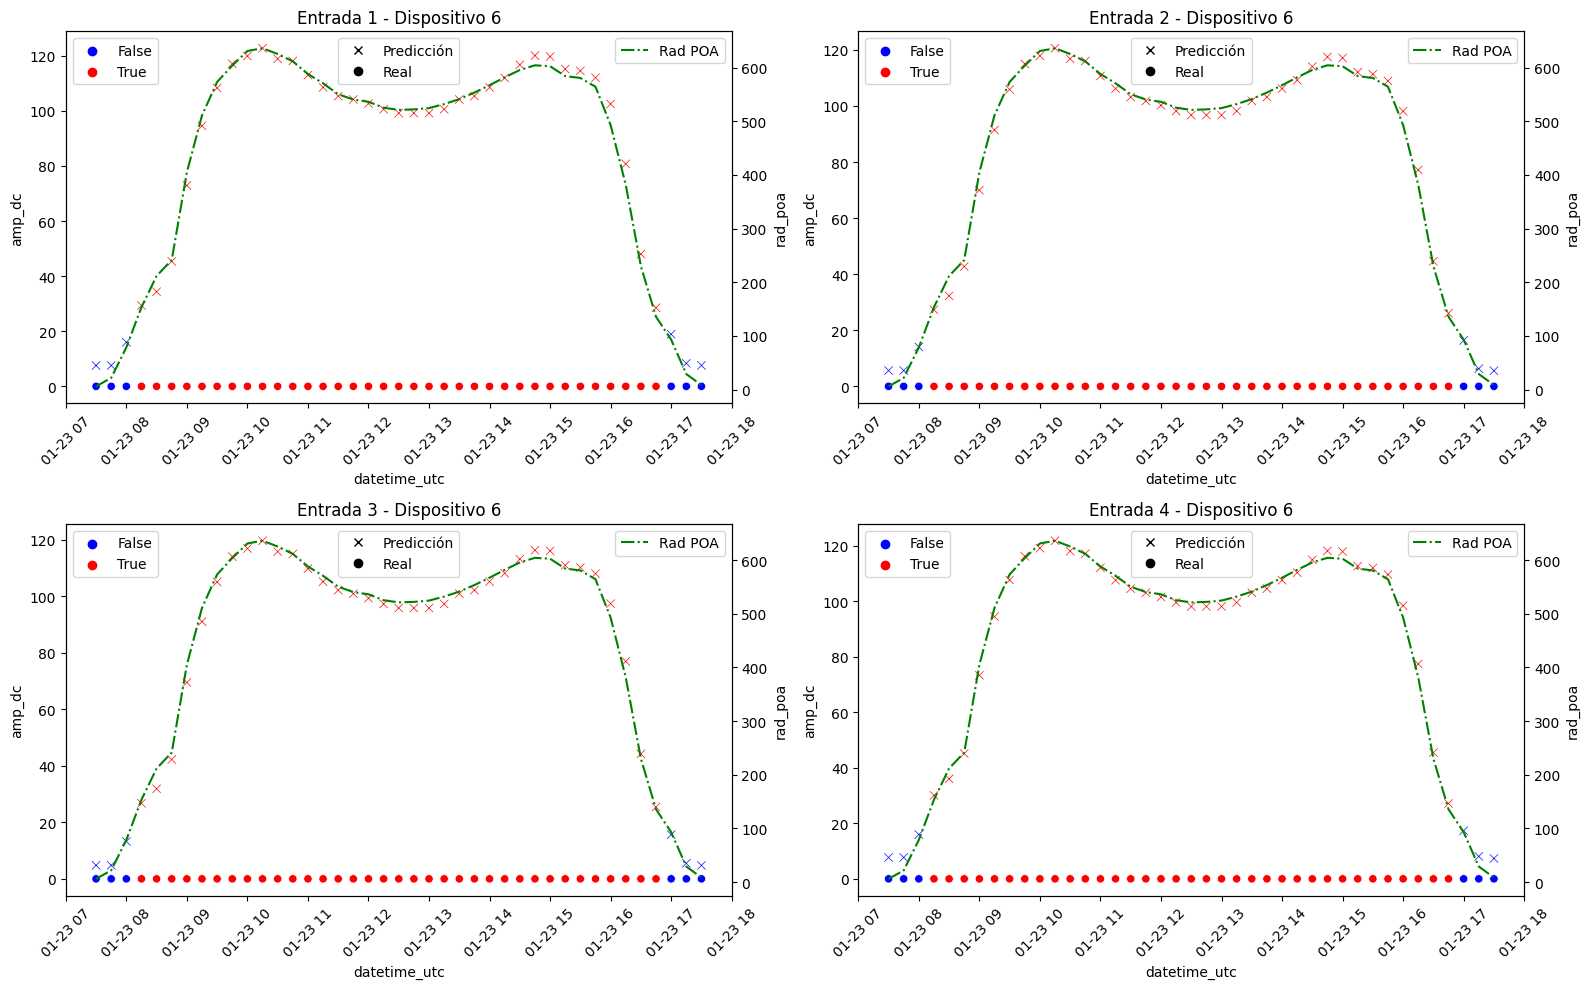

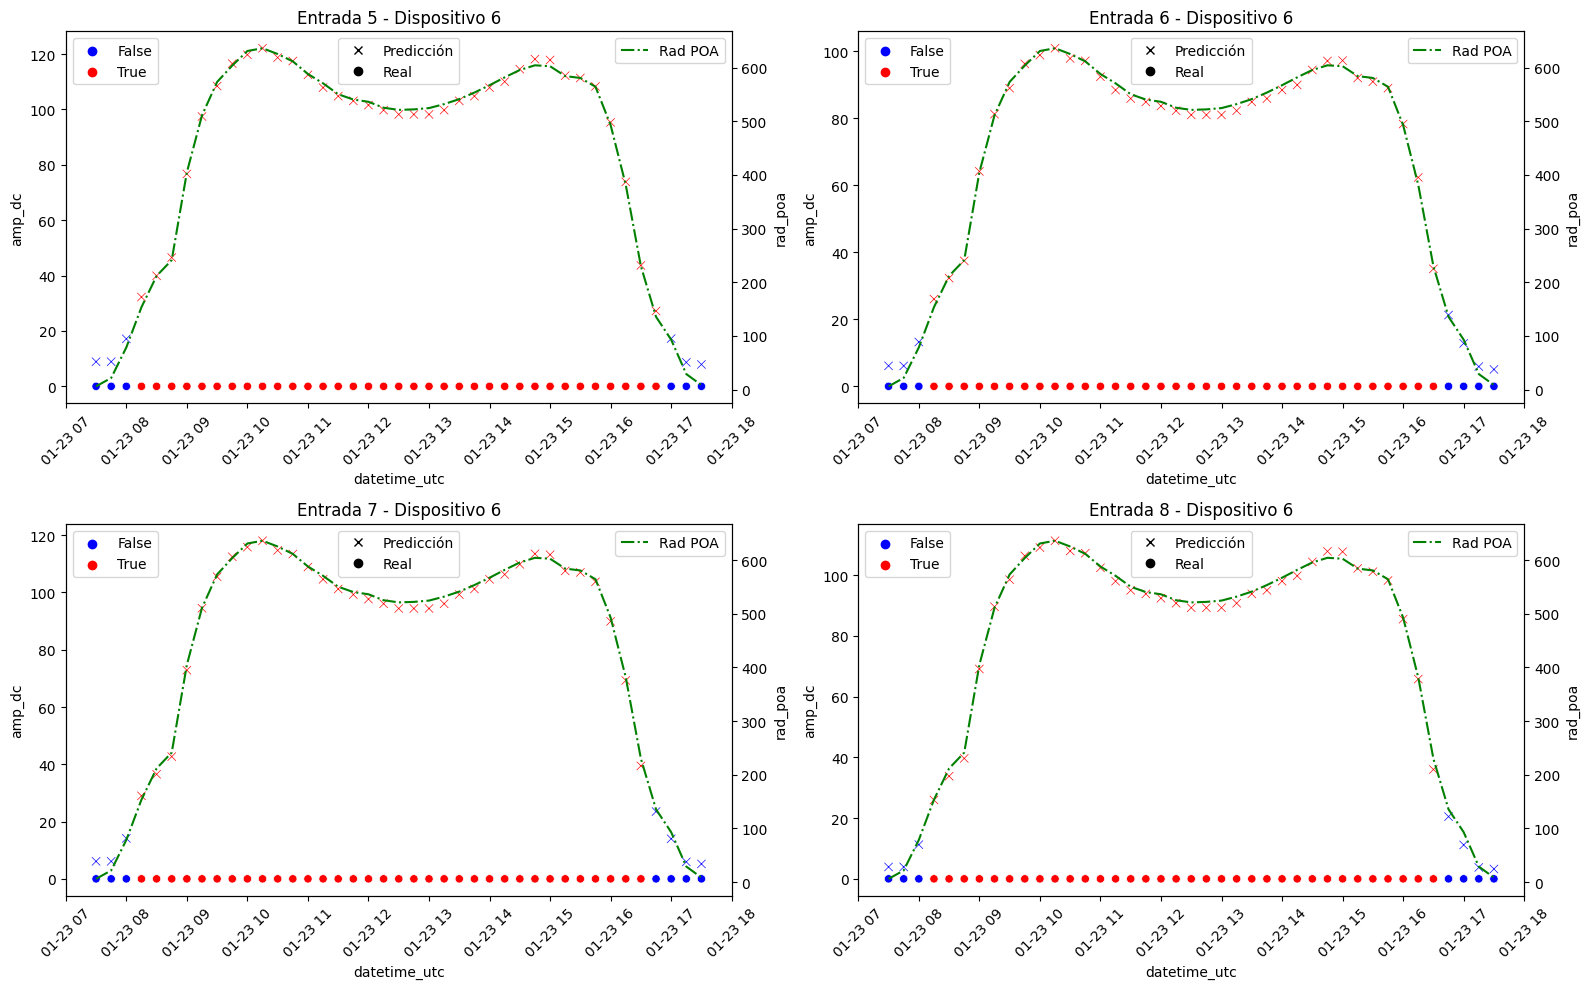

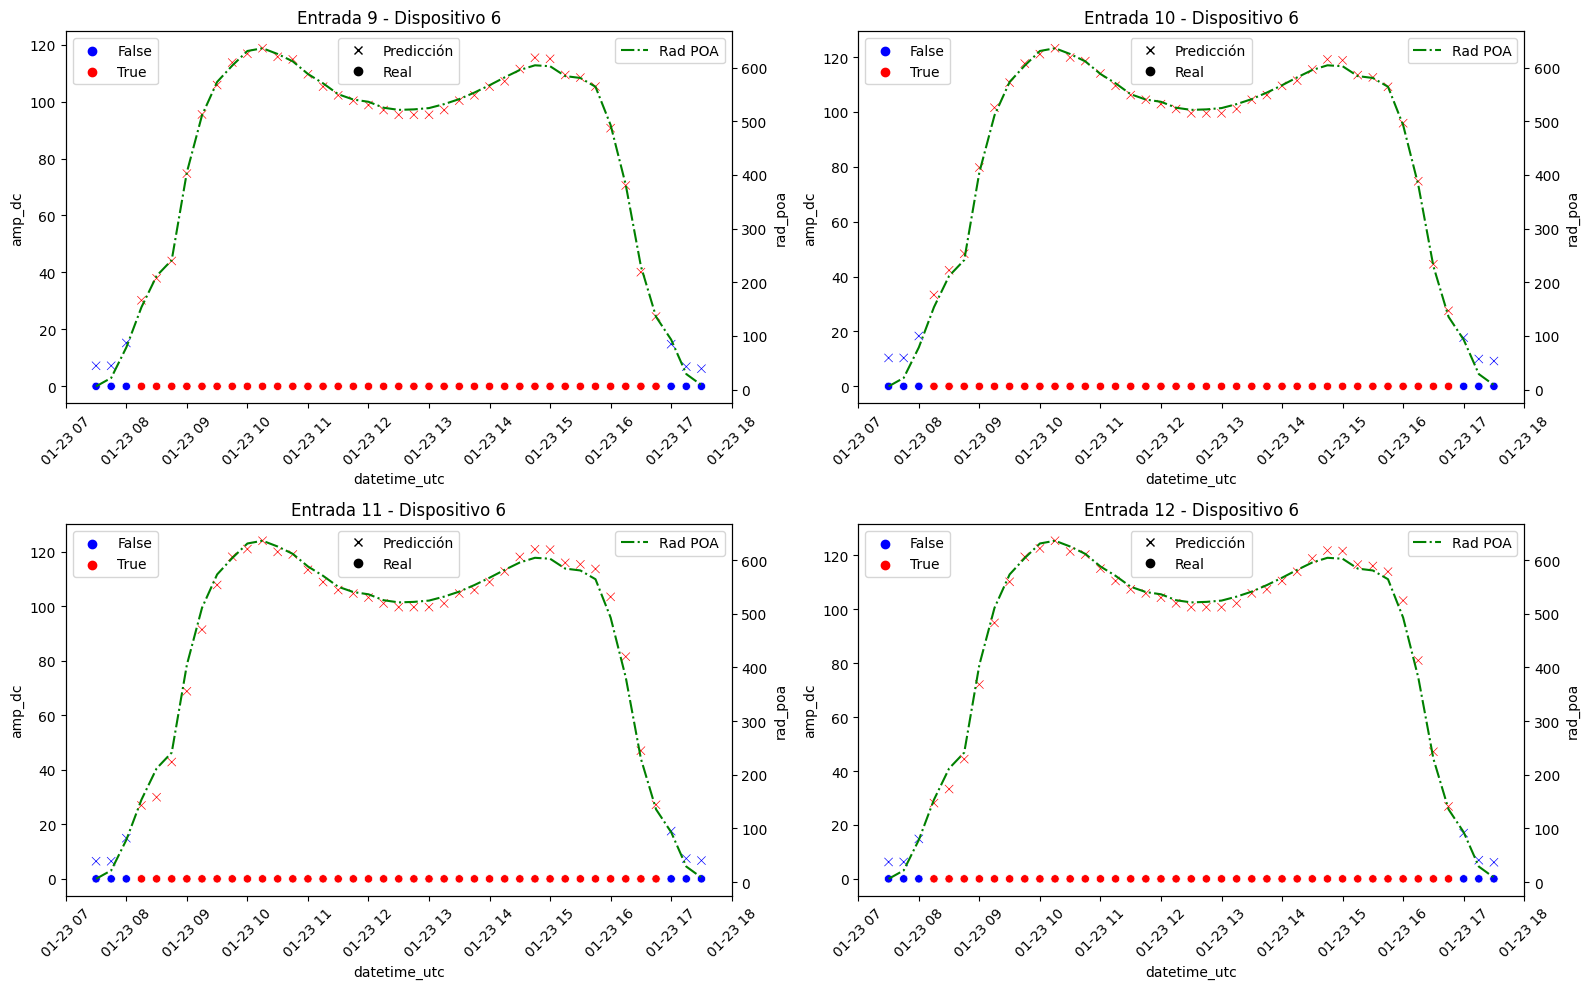

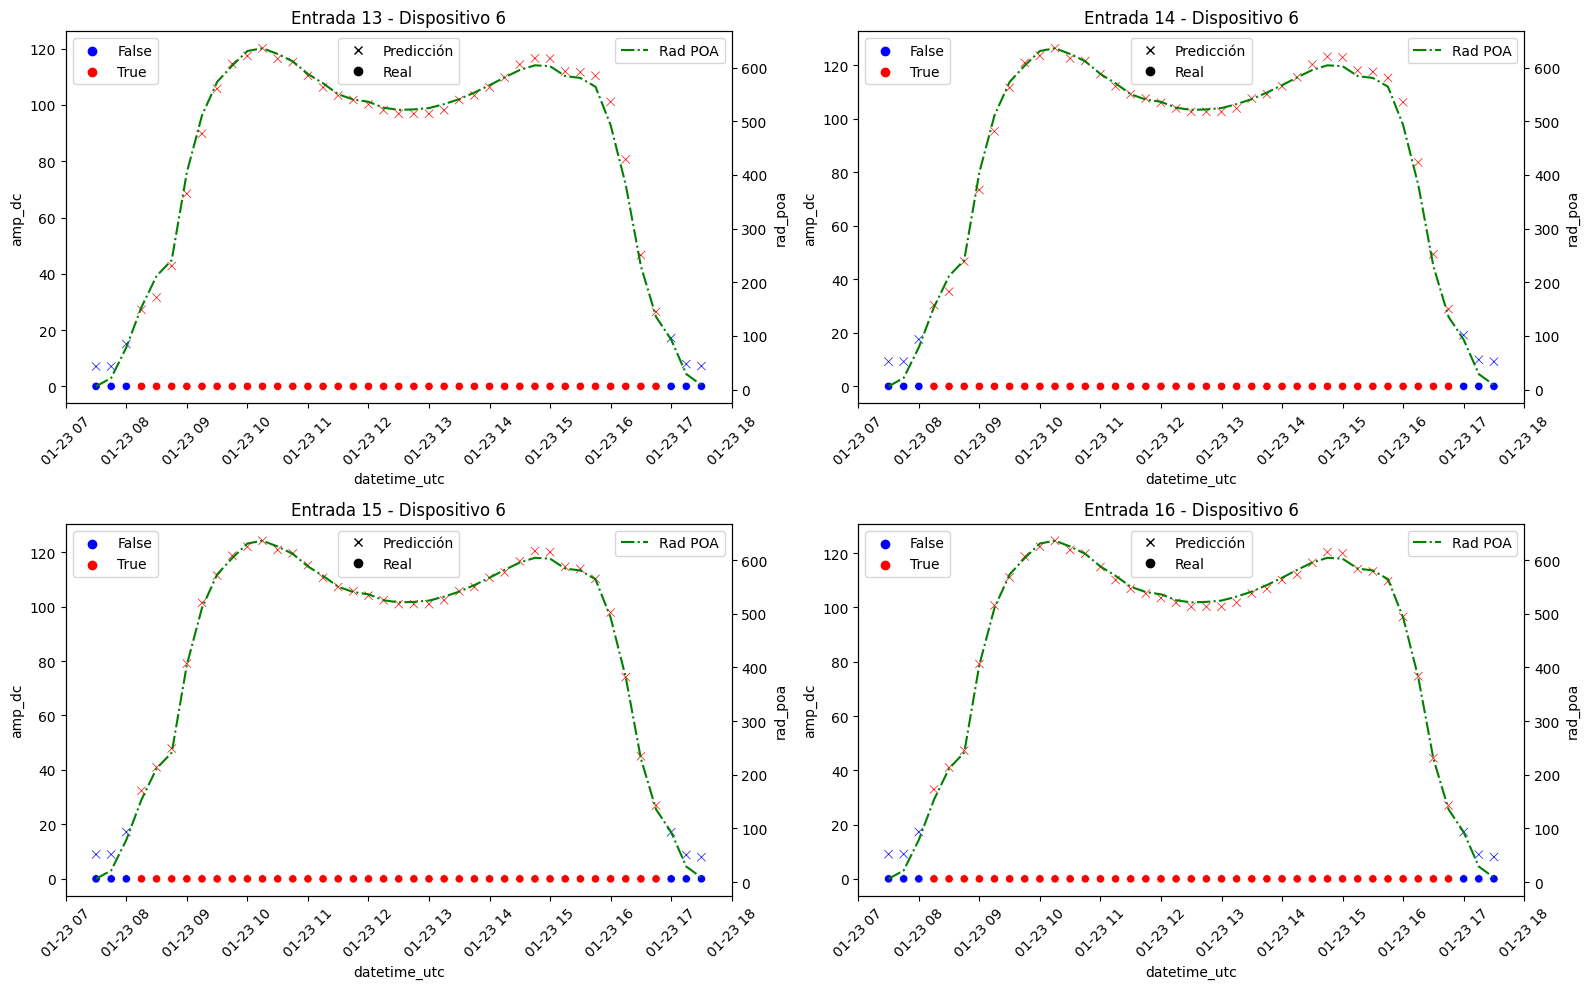

In [72]:
import warnings
from matplotlib.lines import Line2D
import random

error_type = "hard_int_lim"

pred_df['date'] = pred_df['datetime_utc'].dt.date
error_count_df = pd.DataFrame(pred_df[pred_df[error_type]==True].groupby("dispositivo_id")["date"].value_counts() * 100 / \
                              pred_df.groupby("dispositivo_id")["date"].value_counts()) \
                                    .reset_index() \
                                    .sort_values(by=["dispositivo_id", "count"], ascending=[True, False])
random_inv = np.random.choice(error_count_df["dispositivo_id"].unique(), 1)[0]
date = error_count_df[error_count_df["dispositivo_id"] == random_inv].iloc[random.randint(1, 1)]["date"]
sample = pred_df[(pred_df["datetime_utc"].dt.date == date) & (pred_df["dispositivo_id"] == random_inv)].copy()
entrada_ids = np.sort(sample["entrada_id"].unique())
num_entradas = len(entrada_ids)
grupos_entrada_ids = np.array_split(entrada_ids, num_entradas // 4)

warnings.filterwarnings("ignore")

# Imprimir los grupos
for i, grupo in enumerate(grupos_entrada_ids):
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))  # Create a 2x2 grid of subplots
    axs = axs.flatten()
    for j, entrada_id in enumerate(grupo):
        ax2 = axs[j].twinx()
        ax3 = axs[j].twinx()
        sns.scatterplot(data=sample[sample["entrada_id"]==entrada_id], 
                        x="datetime_utc", 
                        y="amp_dc", 
                        hue=error_type,
                        palette=["blue", "red"],
                        legend=True,
                        ax=axs[j])
        
        sns.scatterplot(data=sample[sample["entrada_id"]==entrada_id], 
                        x="datetime_utc", 
                        y="amp_dc_pred", 
                        hue=error_type,
                        marker="x",
                        palette=["blue", "red"],
                        legend=False,
                        ax=axs[j])
        
        sns.lineplot(data=sample[sample["entrada_id"]==entrada_id], 
                    x="datetime_utc", 
                    y="rad_poa", 
                    color="green",
                    linestyle="-.",
                    ax=ax2)
        
        axs[j].legend(loc='upper left')
        ax2.legend(["Rad POA"], loc='upper right')
        axs[j].tick_params(axis='x', rotation=45)
        axs[j].set_title(f"Entrada {entrada_id} - Dispositivo {random_inv - 20}")
        
        # Añadir leyenda adicional para True y False
        ax3.legend(handles=[Line2D([], [], color='black', marker='x', linestyle='None', label = 'Predicción'),
                                Line2D([], [], color='black', marker='o', linestyle='None', label = 'Real')],
                     loc='upper center')
        ax3.axis('off')
        

    plt.tight_layout()
    plt.show()

In [91]:
pred_df

,dispositivo_id,datetime_utc,entrada_id,amp_dc,amp_dc_pred,rad_poa,std_rad_poa,std_diff_rad_poa,coef,rad_bin,error,soft_int_lim,med_int_lim,hard_int_lim,soft_lim,med_lim,hard_lim,inv_outlier,plant_outlier,date
39520,21,2024-01-01 07:45:00+00:00,1,-1.680000,4.092403,14.979310,1.371579,1.235935,7.721274,0-100,-5.772403,False,False,False,True,False,False,False,False,2024-01-01
39521,21,2024-01-01 07:45:00+00:00,2,-0.770000,5.947500,14.979310,1.371579,1.235935,7.721274,0-100,-6.717500,False,False,False,True,False,False,False,False,2024-01-01
39522,21,2024-01-01 07:45:00+00:00,3,1.110000,6.912929,14.979310,1.371579,1.235935,7.721274,0-100,-5.802929,False,False,False,True,False,False,False,False,2024-01-01
39523,21,2024-01-01 07:45:00+00:00,4,1.160000,7.560161,14.979310,1.371579,1.235935,7.721274,0-100,-6.400161,False,False,False,True,False,False,False,False,2024-01-01
39524,21,2024-01-01 07:45:00+00:00,5,4.963333,6.990119,14.979310,1.371579,1.235935,7.721274,0-100,-2.026786,False,False,False,False,False,False,True,True,2024-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157963,33,2024-01-31 17:30:00+00:00,12,8.893333,6.231751,14.740741,1.333493,1.221891,1.914070,0-100,2.661582,False,False,False,False,False,False,True,True,2024-01-31
157964,33,2024-01-31 17:30:00+00:00,13,1.346667,6.190166,14.740741,1.333493,1.221891,1.914070,0-100,-4.843500,False,False,False,False,False,False,False,False,2024-01-31
157965,33,2024-01-31 17:30:00+00:00,14,2.013333,6.899188,14.740741,1.333493,1.221891,1.914070,0-100,-4.885855,False,False,False,False,False,False,False,False,2024-01-31
157966,33,2024-01-31 17:30:00+00:00,15,0.640000,5.530123,14.740741,1.333493,1.221891,1.914070,0-100,-4.890123,False,False,False,False,False,False,False,False,2024-01-31


In [92]:
pd.merge(pd.DataFrame(pred_df["dispositivo_id"].unique(), columns=["dispositivo_id"]), 
         pd.DataFrame(pred_df["entrada_id"].unique(), columns=["entrada_id"]),
        how = "cross")

,dispositivo_id,entrada_id
0,21,1
1,21,2
2,21,3
3,21,4
4,21,5
...,...,...
203,33,12
204,33,13
205,33,14
206,33,15


In [97]:
time_df = pd.DataFrame(pd.date_range(start=X.index.get_level_values("datetime_utc").date.min(), 
                                    end=X.index.get_level_values("datetime_utc").date.max() + pd.Timedelta(days=1), 
                                    freq='15min',
                                    tz = "UTC"),
                        columns=["datetime_utc"])
disp_entrada_df = pd.merge(pd.DataFrame(pred_df["dispositivo_id"].unique(), columns=["dispositivo_id"]), 
         pd.DataFrame(pred_df["entrada_id"].unique(), columns=["entrada_id"]),
        how = "cross")
master_df = pd.merge(time_df, disp_entrada_df, how="cross")
master_df = master_df.merge(sample, on=["datetime_utc", "dispositivo_id", "entrada_id"], how="left")
master_df["amp_dc"] = master_df["amp_dc"].fillna(0)
master_df["amp_dc_pred"] = master_df["amp_dc_pred"].fillna(0)
master_df

,datetime_utc,dispositivo_id,entrada_id,amp_dc,amp_dc_pred,rad_poa,std_rad_poa,std_diff_rad_poa,coef,rad_bin,error,soft_int_lim,med_int_lim,hard_int_lim,soft_lim,med_lim,hard_lim,inv_outlier,plant_outlier,date
0,2024-01-01 00:00:00+00:00,21,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-01 00:00:00+00:00,21,2,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-01 00:00:00+00:00,21,3,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-01 00:00:00+00:00,21,4,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-01 00:00:00+00:00,21,5,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619211,2024-02-01 00:00:00+00:00,33,12,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
619212,2024-02-01 00:00:00+00:00,33,13,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
619213,2024-02-01 00:00:00+00:00,33,14,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
619214,2024-02-01 00:00:00+00:00,33,15,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


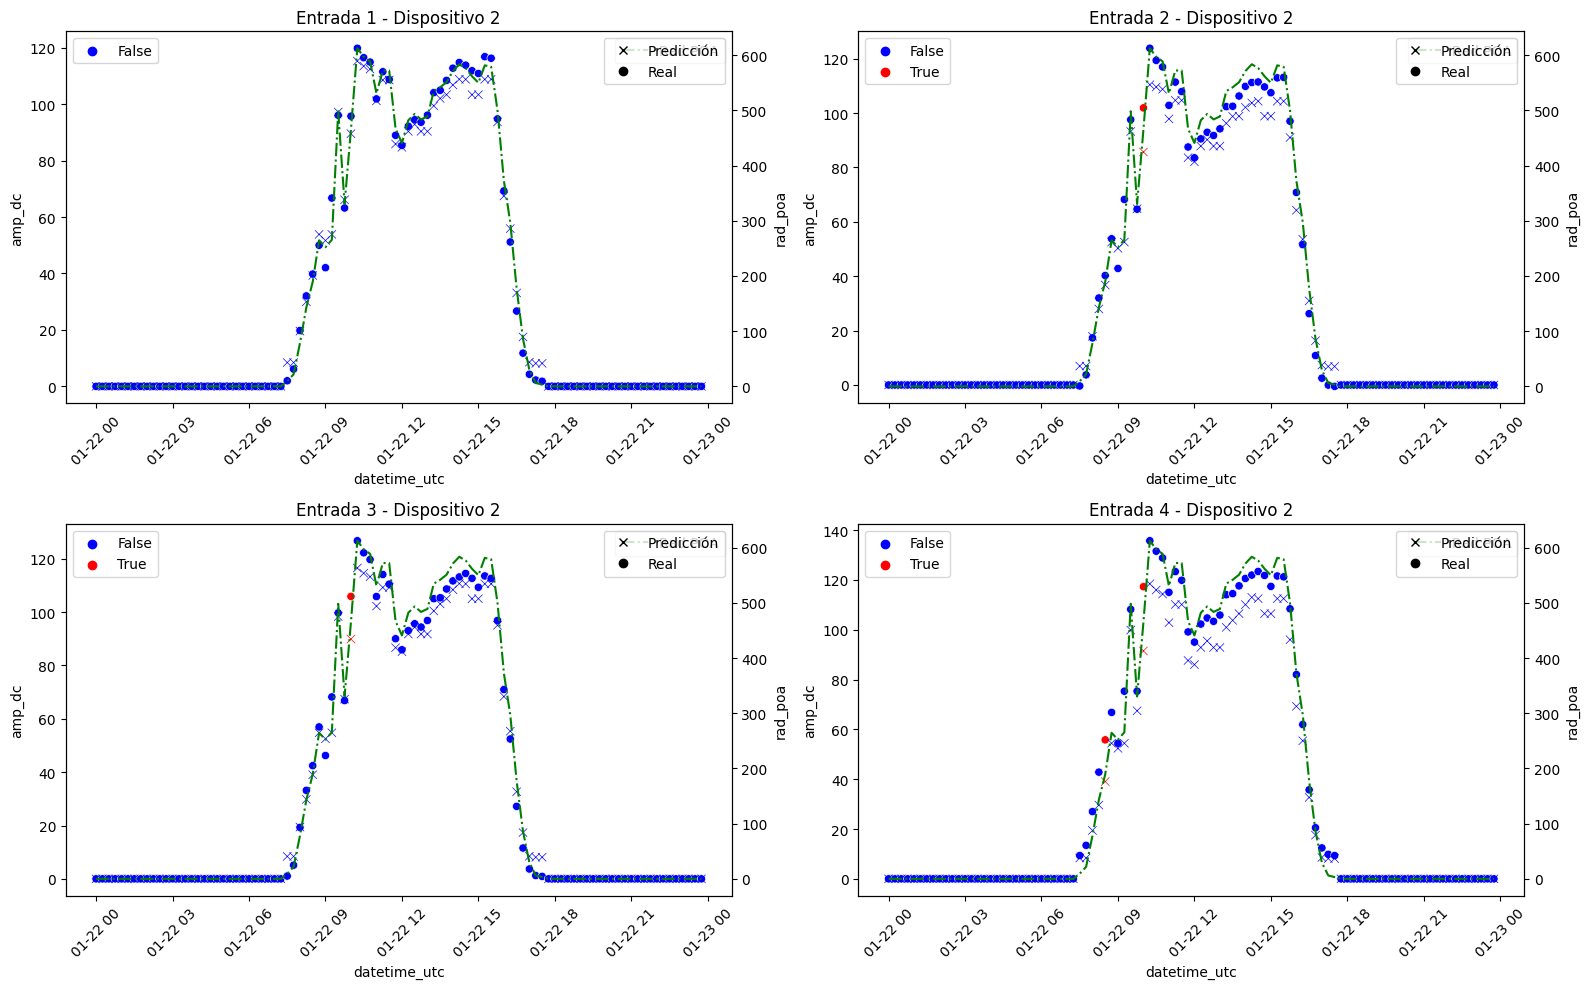

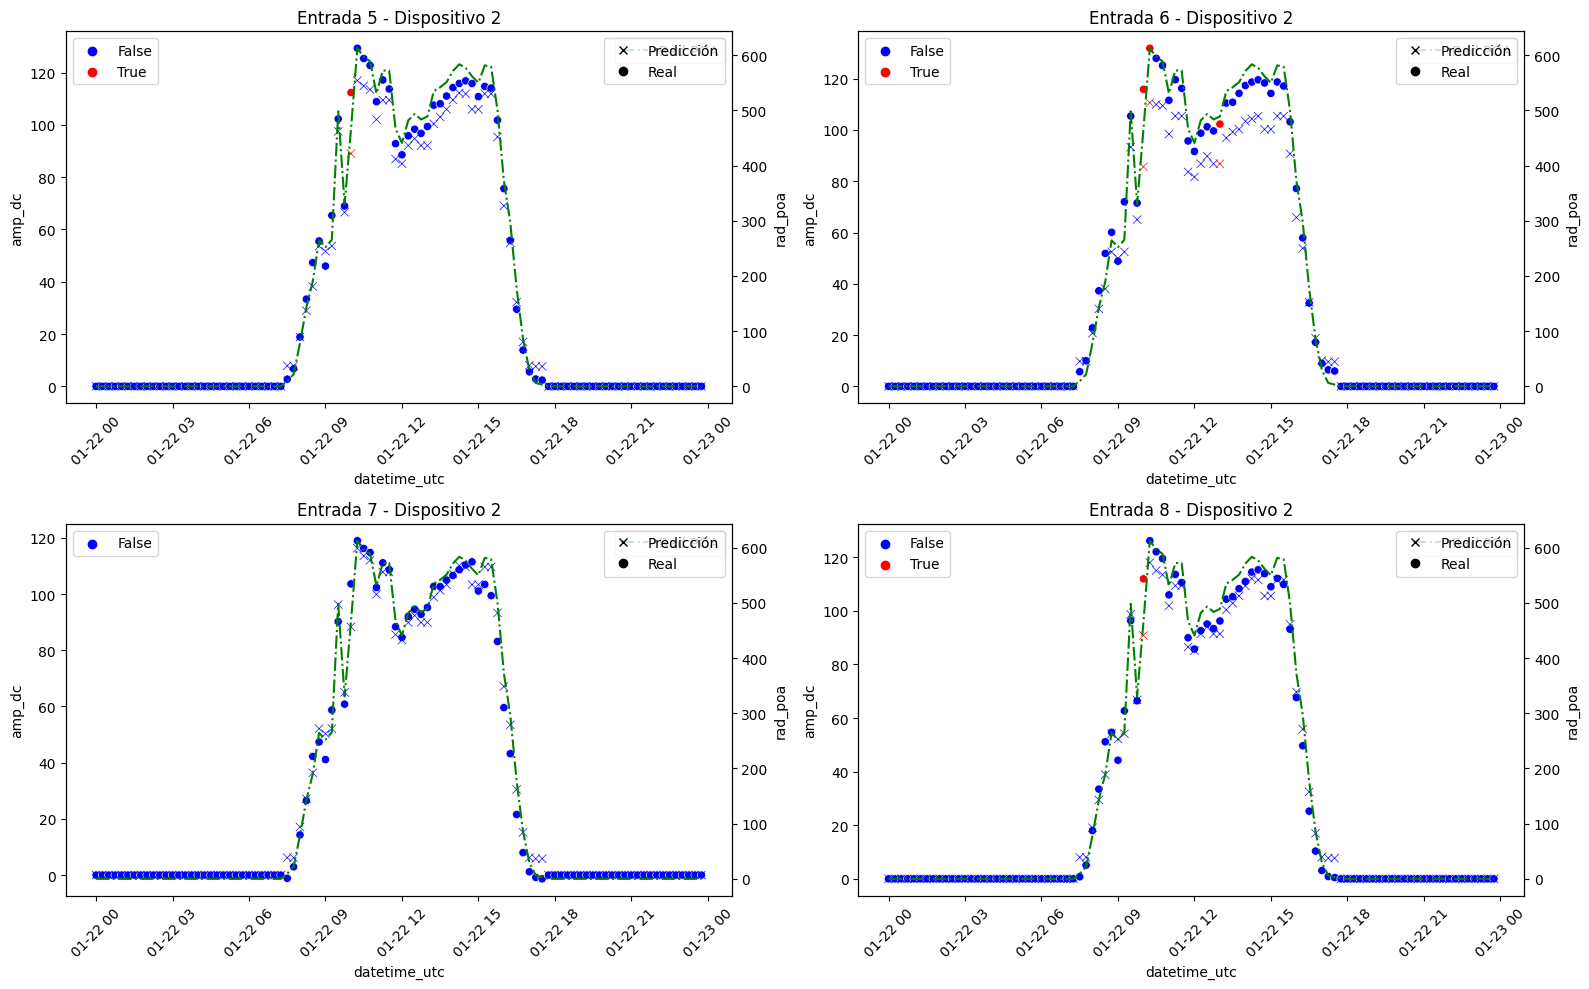

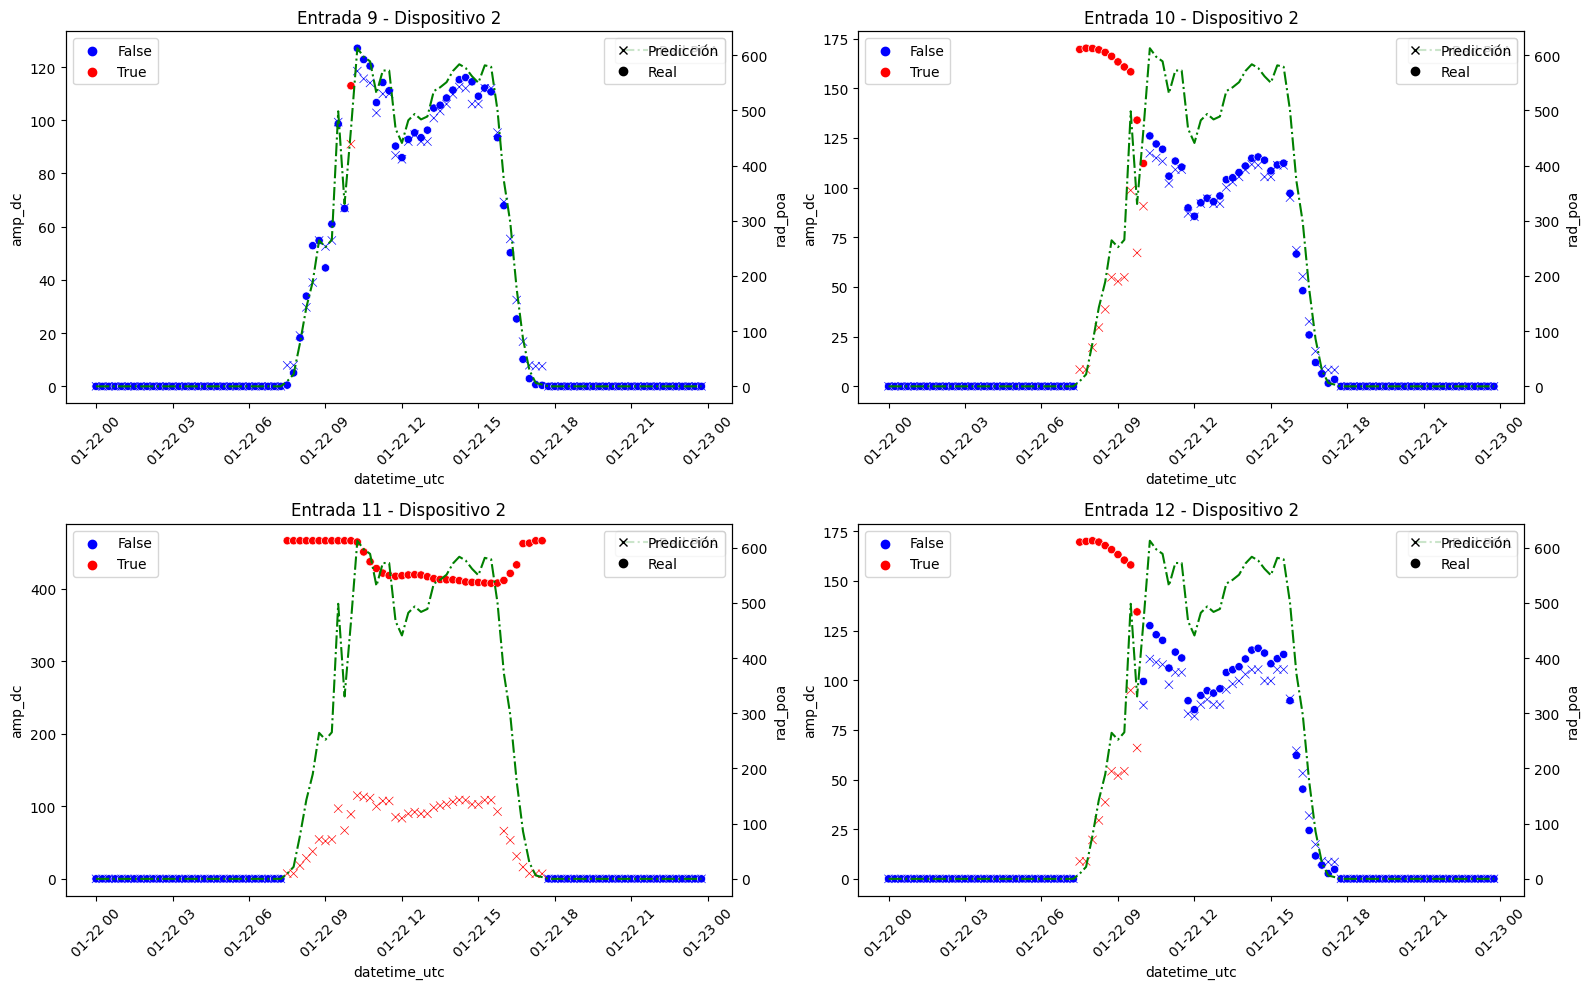

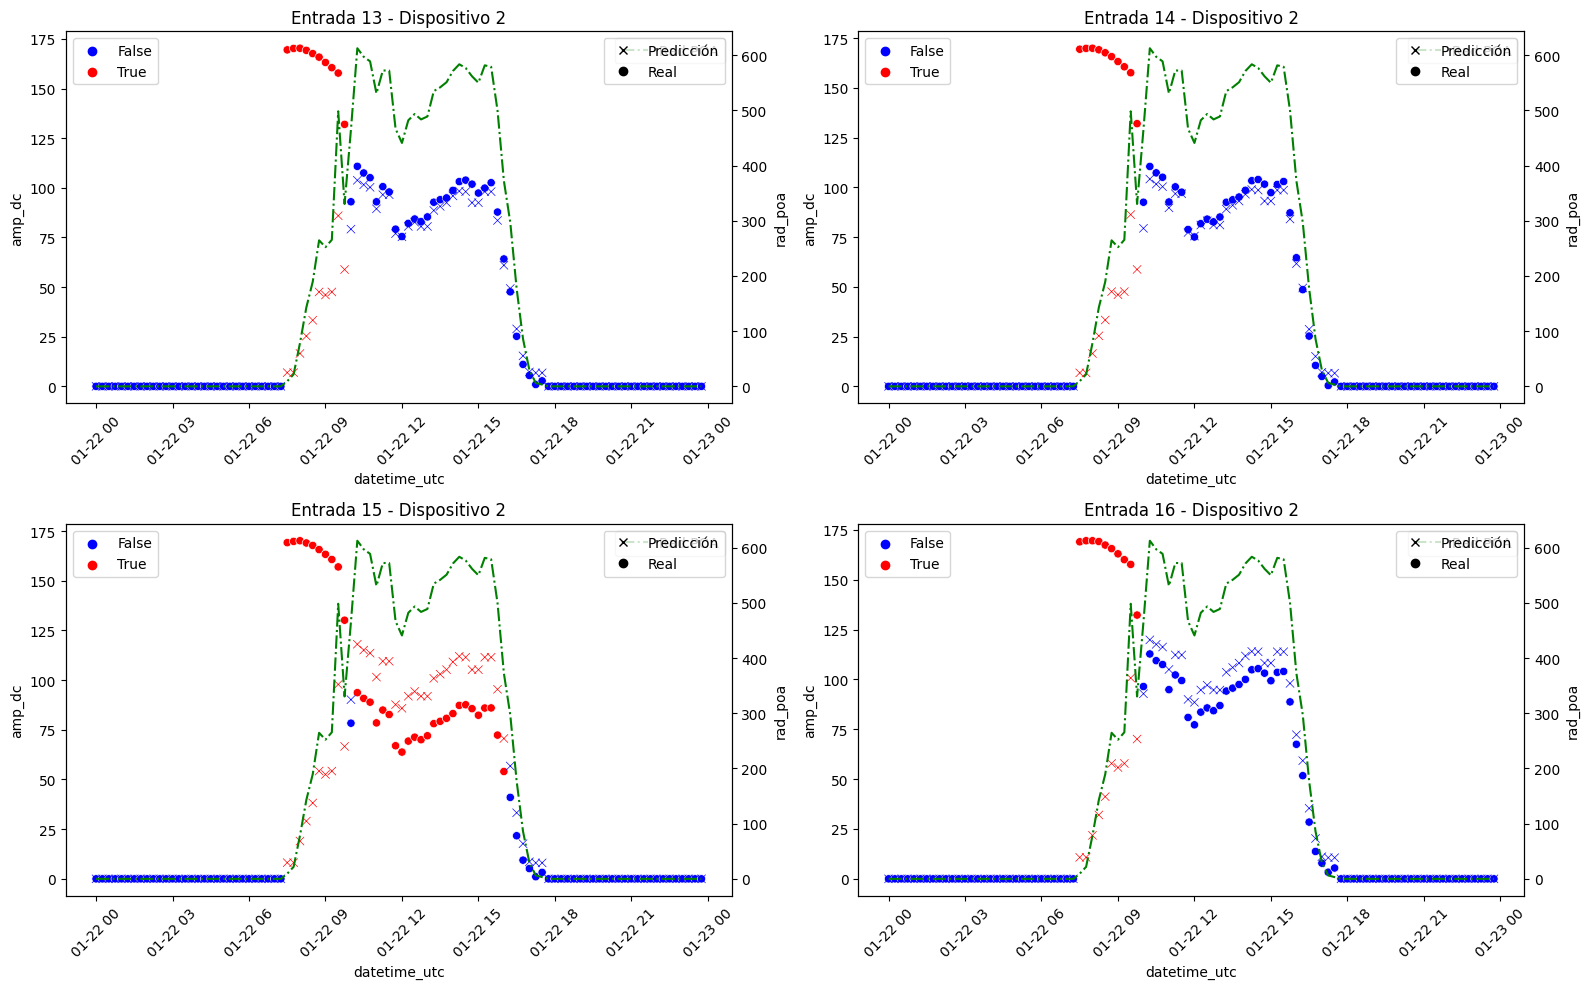

In [102]:
time_df = pd.DataFrame(pd.date_range(start=X.index.get_level_values("datetime_utc").date.min(), 
                                    end=X.index.get_level_values("datetime_utc").date.max() + pd.Timedelta(days=1), 
                                    freq='15min',
                                    tz = "UTC"),
                        columns=["datetime_utc"])
disp_entrada_df = pd.merge(pd.DataFrame(pred_df["dispositivo_id"].unique(), columns=["dispositivo_id"]), 
         pd.DataFrame(pred_df["entrada_id"].unique(), columns=["entrada_id"]),
        how = "cross")
master_df = pd.merge(time_df, disp_entrada_df, how="cross")
master_df = master_df.merge(pred_df, on=["datetime_utc", "dispositivo_id", "entrada_id"], how="left")
master_df["amp_dc"] = master_df["amp_dc"].fillna(0)
master_df["amp_dc_pred"] = master_df["amp_dc_pred"].fillna(0)
master_df["rad_poa"] = master_df["rad_poa"].fillna(0)


import warnings
from matplotlib.lines import Line2D
import random

error_type = "hard_int_lim"
master_df[error_type] = master_df[error_type].fillna(False)

pred_df['date'] = pred_df['datetime_utc'].dt.date
error_count_df = pd.DataFrame(pred_df[pred_df[error_type]==True].groupby("dispositivo_id")["date"].value_counts() * 100 / \
                              pred_df.groupby("dispositivo_id")["date"].value_counts()) \
                                    .reset_index() \
                                    .sort_values(by=["dispositivo_id", "count"], ascending=[True, False])
random_inv = np.random.choice(error_count_df["dispositivo_id"].unique(), 1)[0]
date = error_count_df[error_count_df["dispositivo_id"] == random_inv].iloc[random.randint(1, 1)]["date"]
sample = master_df[(master_df["datetime_utc"].dt.date == date) & (master_df["dispositivo_id"] == random_inv)].copy()
entrada_ids = np.sort(sample["entrada_id"].unique())
num_entradas = len(entrada_ids)
grupos_entrada_ids = np.array_split(entrada_ids, num_entradas // 4)

warnings.filterwarnings("ignore")

# Imprimir los grupos
for i, grupo in enumerate(grupos_entrada_ids):
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))  # Create a 2x2 grid of subplots
    axs = axs.flatten()
    for j, entrada_id in enumerate(grupo):
        ax2 = axs[j].twinx()
        ax3 = axs[j].twinx()
        sns.scatterplot(data=sample[sample["entrada_id"]==entrada_id], 
                        x="datetime_utc", 
                        y="amp_dc", 
                        hue=error_type,
                        palette=["blue", "red"],
                        legend=True,
                        ax=axs[j])
        
        sns.scatterplot(data=sample[sample["entrada_id"]==entrada_id], 
                        x="datetime_utc", 
                        y="amp_dc_pred", 
                        hue=error_type,
                        marker="x",
                        palette=["blue", "red"],
                        legend=False,
                        ax=axs[j])
        
        sns.lineplot(data=sample[sample["entrada_id"]==entrada_id], 
                    x="datetime_utc", 
                    y="rad_poa", 
                    color="green",
                    linestyle="-.",
                    ax=ax2)
        
        axs[j].legend(loc='upper left')
        ax2.legend(["Rad POA"], loc='upper right')
        axs[j].tick_params(axis='x', rotation=45)
        axs[j].set_title(f"Entrada {entrada_id} - Dispositivo {random_inv - 20}")
        
        # Añadir leyenda adicional para True y False
        ax3.legend(handles=[Line2D([], [], color='black', marker='x', linestyle='None', label = 'Predicción'),
                                Line2D([], [], color='black', marker='o', linestyle='None', label = 'Real')],
                     loc='best')
        ax3.axis('off')
        

    plt.tight_layout()
    plt.show()
